## Gender Classification with Perceptron using First Names

In [96]:
# import all the required libraries
import hashlib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [97]:
# Generating a personalized random seed
username = "prit.kanadiya"
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
print(seed)
random.seed(seed)

1379217023


In [98]:
df = pd.read_csv("../assets/data/gender.csv")
df["Name"] = df["Name"].str.lower()    # Keeping all names in lowercase
print(df.head())

      Name  Target
0     yash       1
1     prit       1
2     meet       1
3  drashti       0
4   saloni       0


In [99]:
# The dataset is approximately balanced
sub_df = df[df["Target"] == 0]
print(f"Number of girls in dataset: {len(sub_df)}")
sub_df = df[df["Target"] == 1]
print(f"Number of girls in dataset: {len(sub_df)}")

Number of girls in dataset: 679
Number of girls in dataset: 615


In [100]:
# Convert each name to feature vector
X = []
y = []

# Considering all unigrams, all bigrams, and all trigrams in name and a binary feature indicating whether the last character is a vowel
# We only take the last character because we know in Indian names, last character being vowel can be useful
num_feats = 26 + 26*26 + 26*26*26 + 1 + 1  # 26 letters + 26*26 bigrams + 26*26*26 trigrams + 1 is_vowel + 1 bias = 18280 features

for i in range(len(df)):
    name = df.iloc[i]['Name']
    target = df.iloc[i]['Target']
    name = name.lower()

    vec = np.zeros(num_feats)
    vec[num_feats-1] = 1   # Initialize bias term as 1

    # Consider last character of name
    if (name[-1] == "a" or name[-1] == "e" or name[-1] == "i" or name[-1] == "o" or name[-1] == "u"):
        vec[num_feats-2] = 1

    # Consider all unigrams
    for j in range(len(name)):
        index = ord(name[j]) - 97
        vec[index] += 1

    # Consider all bigrams
    for j in range(len(name)-1):
        bigram = name[j:j+2]
        index = 26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)
        vec[index] += 1

    # Consider all trigrams
    for k in range(len(name)-2):
        trigram = name[k:k+3]
        index = 26 + 26*26 + (ord(trigram[0]) - 97)*26*26 + (ord(trigram[1]) - 97)*26 + (ord(trigram[2]) - 97)
        vec[index] += 1

    vec = vec.reshape(-1, 1)
    X.append(vec)

    if target == 0:
        # -1 represents girl
        y.append(-1)
    else:
        # 1 represents boy
        y.append(1)

# Printing sample feature vector and label
print(X[0].shape)
print(y[0])

(18280, 1)
1


In [101]:
# Split data into train and test sets
test_size = 0.1

data = list(zip(X, y))
random.shuffle(data)

split_index = int(len(data) * (1 - test_size))
train_data = data[:split_index]
test_data = data[split_index:]

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')

Number of training examples: 1164
Number of test examples: 130


In [102]:
class Perceptron():
    def __init__(self, num_feats):
        self.num_feats = num_feats
        self.W = np.zeros((self.num_feats, 1))
    
    def fit(self, X, y, threshold=1000):
        m = X.shape[0]
        misclassifications = []  # List to store misclassifications at each iteration

        num_iterations = 0
        # Continue till labels are classified
        while True:
            miss = 0
            for j in range(m):
                Z = y[j]*(np.dot(self.W.T, X[j]))
                if (Z[0][0] <= 0):
                    self.W = self.W + y[j]*X[j]
                    miss += 1
            
            misclassifications.append(miss)

            if (num_iterations % 10 == 0):
                print(f"Iteration {num_iterations}: {miss} misclassifications")
                
            num_iterations += 1

            if (miss == 0):
                print(f"Iteration {num_iterations}: Converged!")
                break
                
            if (num_iterations > threshold):
                print("Algorithm did not converge!")
                break
            
        return misclassifications
    
    def get_accuracy(self, X, y):
        m = X.shape[0]
        print(f"Total number of test samples: {m}")

        miss = 0
        confusion_matrix = [[0, 0], [0, 0]]    # This is [[TP, FP], [FN, TN]]
        for j in range(m):
            Z = y[j]*(np.dot(self.W.T, X[j]))
            if (Z[0][0] <= 0):
                miss += 1
                if (y[j] == -1):    
                    confusion_matrix[0][1] += 1
                else:
                    confusion_matrix[1][0] += 1
                continue
            
            if (y[j] == -1):
                confusion_matrix[1][1] += 1
            else:
                confusion_matrix[0][0] += 1
        
        print(f"Number of misclassified samples: {miss}")
        return (m-miss)/m, confusion_matrix
    
    def predict(self, test_name):
        # Convert name to feature vector
        name = test_name.lower()
        vec = np.zeros(self.num_feats)
        vec[self.num_feats-1] = 1   # Initialize bias term as 1

        # Consider last character of name
        if (name[-1] == "a" or name[-1] == "e" or name[-1] == "i" or name[-1] == "o" or name[-1] == "u"):
            vec[self.num_feats-2] = 1

        # Consider all unigrams
        for j in range(len(name)):
            index = ord(name[j]) - 97
            vec[index] += 1

        # Consider all bigrams
        for j in range(len(name)-1):
            bigram = name[j:j+2]
            index = 26 + (ord(bigram[0]) - 97)*26 + (ord(bigram[1]) - 97)
            vec[index] += 1

        # Consider all trigrams
        for k in range(len(name)-2):
            trigram = name[k:k+3]
            index = 26 + 26*26 + (ord(trigram[0]) - 97)*26*26 + (ord(trigram[1]) - 97)*26 + (ord(trigram[2]) - 97)
            vec[index] += 1

        vec = vec.reshape(-1, 1)
        
        z = np.dot(self.W.T, vec)

        if z > 0:
            print("I am sure " + test_name + " is a boy.")
        elif z < 0:
            print("I am sure " + test_name + " is a girl.")
        else:
            print("I am not sure if " + test_name + " is a boy or a girl.")

In [103]:
perceptron = Perceptron(num_feats)
misclassifications = perceptron.fit(X_train, y_train)

Iteration 0: 271 misclassifications
Iteration 10: 48 misclassifications
Iteration 20: 29 misclassifications
Iteration 30: 22 misclassifications
Iteration 40: 17 misclassifications
Iteration 50: 17 misclassifications
Iteration 60: 18 misclassifications
Iteration 70: 6 misclassifications
Iteration 80: 3 misclassifications
Iteration 90: 5 misclassifications
Iteration 98: Converged!


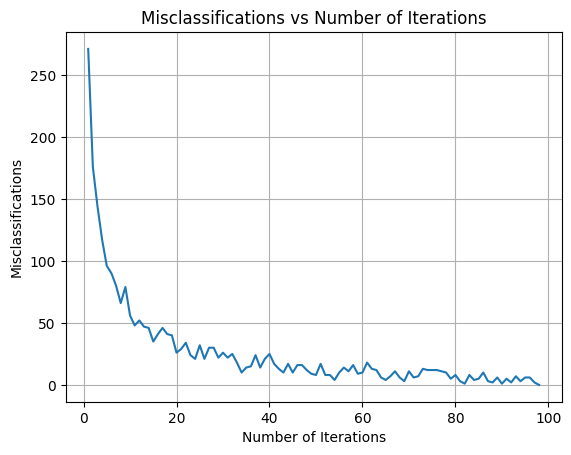

In [104]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(misclassifications) + 1), misclassifications)
plt.xlabel('Number of Iterations')
plt.ylabel('Misclassifications')
plt.title('Misclassifications vs Number of Iterations')
plt.grid(True)
plt.show()

In [105]:
accuracy, confusion_matrix = perceptron.get_accuracy(X_test, y_test)
print(f"Accuracy on test set: {accuracy}")
print(f"Confusion Matrix: {confusion_matrix}")

Total number of test samples: 130
Number of misclassified samples: 15
Accuracy on test set: 0.8846153846153846
Confusion Matrix: [[55, 7], [8, 60]]


In [ ]:
# Testing with our own example
# We choose slightly difficult names for Indian names
print("Indian Names:")
names = ["Asin", "Anvay", "Samantha", "Raavan", "Mandodari", "Zooni", "Chandanbala"]
for name in names:
    perceptron.predict(name)
print()
# Model gets Asin wrong

# These are foreign names, so they won't perform as well as Indian names since the data used comes from Indian names only.
# We try on some easy names for foreign names
# For Meryl, the feature vector lies on the hyperplane, hence we are not sure about gender
print("Foreign Names:")
names = ["Emma", "Jacob", "Carlos", "Hermoine", "Leonardo", "Meryl", "Obama"]  
for name in names:
    perceptron.predict(name)
# Model gets Leonardo, Meryl, Obama wrong

Indian Names:
I am sure Asin is a boy.
I am sure Anvay is a boy.
I am sure Samantha is a girl.
I am sure Raavan is a boy.
I am sure Mandodari is a girl.
I am sure Zooni is a girl.
I am sure Chandanbala is a girl.

Foreign Names:
I am sure Emma is a girl.
I am sure Jacob is a boy.
I am sure Carlos is a boy.
I am sure Hermoine is a girl.
I am sure Leonardo is a girl.
I am not sure if Meryl is a boy or a girl.
I am sure Obama is a girl.


In [107]:
# Verifying implementation using scikit learn
from sklearn.linear_model import Perceptron

# Removing the extra dimension
X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train)
X_test = np.squeeze(X_test)
y_test = np.squeeze(y_test)

# Initialize the Perceptron model
model = Perceptron()
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)

print("Accuracy using scikit learn:", accuracy)

Accuracy using scikit learn: 0.8769230769230769
